# Word2Vec (Skipgram )

In [1]:
# !pip install matplotlib
# !pip install pyarrow
# !pip install torchtext
# !pip install nltk
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import collections

In [32]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# import pandas as pd


# import pandas as pd

# # Example DataFrame (assuming you already have one)
# df = pd.DataFrame({
#     'text': [
#         "The quick brown fox jumped over the lazy dog.",
#         "This is another example sentence for processing.",
#         "Data science is fun and challenging!"
#     ]
# })

# #1. tokenization
# corpus = df['text']
# corpus = [sent.split(" ") for sent in corpus]
# df['text'] = corpus



# # Apply the preprocessing function
# corpus = df['text'].apply(lambda x: rpuncst(x))


# #2. numeralization
# #find unique words
# flatten = lambda l: [item for sublist in l for item in sublist]
# #assign unique integer
# vocabs = list(set(flatten(corpus)))

# word2index = {v:idx for idx, v in enumerate(vocabs)}


# len(vocabs)

11

In [2]:
np.__version__, torch.__version__

('2.2.0', '2.5.1+cu124')

In [3]:
import matplotlib
matplotlib.__version__

'3.10.0'

## 1. Load data

In [4]:
!wget https://huggingface.co/api/datasets/fancyzhx/yelp_polarity/parquet/plain_text/train/0.parquet -o train0.parquet

In [2]:
df=pd.read_parquet('0.parquet')
df['text'] = df['text'].astype('unicode')

In [3]:
#1. tokenization
corpus = df['text']
corpus = [sent.split(" ") for sent in corpus]
df['text'] = corpus

In [7]:
df.head()

,text,label
0,"[Unfortunately,, the, frustration, of, being, ...",0
1,"[Been, going, to, Dr., Goldberg, for, over, 10...",1
2,"[I, don't, know, what, Dr., Goldberg, was, lik...",0
3,"[I'm, writing, this, review, to, give, you, a,...",0
4,"[All, the, food, is, great, here., But, the, b...",1


**The data is yelp review polarity dataset the sample size is smaller upto 5600000 rows with label as sentiments**

In [550]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     st125490/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     st125490/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def rpuncst(x):
     # Remove punctuation and stopwords
    # tokens = [token.lower() for token in tokens]
    # Apply stemming to each token
    tokens = [token for token in x if token.isalnum() and token.lower() not in stop_words]    
    return tokens

corpus = df['text'][:1000]
corpus=corpus.apply(lambda x: rpuncst(x))

In [5]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [6]:
len(vocabs)

8742

In [7]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['food']

6055

In [8]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 0

In [9]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'screened'

In [10]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device, torch.cuda.get_device_name(0))

cuda:2 NVIDIA GeForce RTX 2080 Ti


## 2. Prepare train data

In [11]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus, word2index):
    skipgrams = []

    # Generate skipgrams for the corpus
    for doc in corpus:
        for i in range(1, len(doc) - 1):  # Skip the first and last words
            center = word2index[doc[i]]
            outside = (word2index[doc[i - 1]], word2index[doc[i + 1]])
            for each_out in outside:
                skipgrams.append([center, each_out])

    # Randomly select a batch
    random_indices = torch.randperm(len(skipgrams))[:batch_size]

    # Create input and label tensors for the batch
    inputs = torch.tensor([skipgrams[i][0] for i in random_indices], dtype=torch.long).view(-1, 1)
    labels = torch.tensor([skipgrams[i][1] for i in random_indices], dtype=torch.long).view(-1, 1)

    return inputs, labels
            
x, y = random_batch(2, corpus, word2index)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7944184793d0>>
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7944184793d0>>
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [15]:
x.shape  #batch_size, 1

torch.Size([2, 1])

In [16]:
x=torch.tensor(x).to(device)
x

/tmp/ipykernel_580917/3384216390.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x).to(device)


tensor([[4233],
        [7121]], device='cuda:2')

In [17]:
y=torch.tensor(y).to(device)
y.shape  #batch_size 1

/tmp/ipykernel_580917/805259562.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y).to(device)


torch.Size([2, 1])

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [18]:
len(vocabs)

8743

In [19]:
embedding = nn.Embedding(8743, 2)
embedding = embedding.to(device)

In [20]:
x_tensor=x.clone()
embedding(x_tensor).shape  #(batch_size, 1, emb_size)

torch.Size([2, 1, 2])

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [12]:
class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size).to(device)
        self.embedding_outside = nn.Embedding(voc_size, emb_size).to(device)

    def forward(self, center, outside, all_vocabs):
        # Ensure the correct size for center and outside embeddings
        # batch_size x 1 x emb_size
        center_embedding = self.embedding_center(center)  # Shape: [batch_size, emb_size]
        outside_embedding = self.embedding_outside(outside)  # Shape: [batch_size, emb_size]
        all_vocabs_embedding = self.embedding_outside(all_vocabs)  # Shape: [batch_size, voc_size, emb_size]

        # You need to reshape the embeddings to match the required shape for bmm
        # center_embedding = center_embedding.view(-1, 1, emb_size)  # Shape: [batch_size, 1, emb_size]
        # outside_embedding = outside_embedding.view(-1, 1, emb_size)  # Shape: [batch_size, 1, emb_size]

        # All vocab embeddings: [batch_size, voc_size, emb_size]

        # Perform the batch matrix multiplication
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))  # Shape: [batch_size]
        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)  # Shape: [batch_size, voc_size]

        # Compute the sum for the lower term
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  # Shape: [batch_size]

        # Compute the loss
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  # Scalar loss

        return loss


In [22]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[   0,    1,    2,  ..., 8740, 8741,    0],
        [   0,    1,    2,  ..., 8740, 8741,    0]])

In [23]:
all_vocabs[0].shape

torch.Size([8743])

In [24]:
model = Skipgram(voc_size, 2).to(device)
model
# model = Skipgram(voc_size, 2)
# model

Skipgram(
  (embedding_center): Embedding(8743, 2)
  (embedding_outside): Embedding(8743, 2)
)

In [25]:
# input_tensor = torch.LongTensor(x)
# label_tensor = torch.LongTensor(y)
input_tensor =x.clone()
label_tensor=y.clone()

In [26]:
input_tensor

tensor([[4233],
        [7121]], device='cuda:2')

In [27]:
all_vocabs=all_vocabs.to(device)

In [28]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [29]:
loss

tensor(9.7814, device='cuda:2', grad_fn=<NegBackward0>)

## 4. Training

In [26]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size).to(device)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [27]:
num_epochs = 2000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus, word2index)
    # input_tensor = torch.LongTensor(input_batch).to(device)
    # label_tensor = torch.LongTensor(label_batch).to(device)
    # input_tensor=torch.tensor(input_batch, dtype=torch.long, device=device)
    # label_tensor = torch.tensor(label_batch, dtype=torch.long, device=device)
    input_tensor = input_batch.to(device).type(torch.long)
    label_tensor = label_batch.to(device).type(torch.long)

    
    #predict
    # all_vocabs = torch.tensor(range(vocab_size), dtype=torch.long, device=device).unsqueeze(0).repeat(batch_size, 1)
    loss = model(input_tensor, label_tensor, all_vocabs)
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    #update alpha
    optimizer.step()

    torch.cuda.empty_cache()
    
    #print the loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch    100 | Loss: 9.497332
Epoch    200 | Loss: 9.737602
Epoch    300 | Loss: 10.293623
Epoch    400 | Loss: 9.736547
Epoch    500 | Loss: 10.155918
Epoch    600 | Loss: 9.517531
Epoch    700 | Loss: 9.038460
Epoch    800 | Loss: 9.263144
Epoch    900 | Loss: 9.355503
Epoch   1000 | Loss: 9.315777
Epoch   1100 | Loss: 8.967062
Epoch   1200 | Loss: 9.685616
Epoch   1300 | Loss: 8.967436
Epoch   1400 | Loss: 8.997517
Epoch   1500 | Loss: 8.418997
Epoch   1600 | Loss: 9.702528
Epoch   1700 | Loss: 9.494498
Epoch   1800 | Loss: 12.174791
Epoch   1900 | Loss: 9.226822
Epoch   2000 | Loss: 9.902236


**The text words are dense so, the traning error is not improving ultiple the window size is increased, reducing the number of epochs inverable to performance**

In [98]:
print(model.embedding_center.weight.device)

cuda:0


## 5. Plot the embeddings

Is fruit really near to banana?
Is fruit really far from cat?

In [50]:
vocabs[:5]

['decided', 'located', 'avocados', 'rethink', 'poodle']

In [51]:
# banana = torch.LongTensor([word2index['food']])
# banana
banana=torch.tensor([word2index['food']], dtype=torch.long, device=device)

In [52]:
banana_embed_c = model.embedding_center(banana).to(device)
banana_embed_o = model.embedding_outside(banana).to(device)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[ 0.8631, -0.0923]], device='cuda:0', grad_fn=<DivBackward0>)

In [53]:
banana_embed_o

tensor([[2.1261, 1.1664]], device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [54]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    # word = torch.LongTensor([word2index[word]])
    word =torch.tensor([word2index[word]], dtype=torch.long, device=device)
    
    embed_c = model.embedding_center(word).to(device)
    embed_o = model.embedding_outside(word).to(device)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [55]:
get_embed('food')

(0.8631033301353455, -0.09226888418197632)

In [56]:
get_embed('burger')

(0.8341680765151978, 0.2952005863189697)

In [57]:
get_embed('yummy')

(-0.7472754716873169, -0.12508422136306763)

In [58]:
get_embed('worst')

(-0.019122764468193054, 0.6056886315345764)

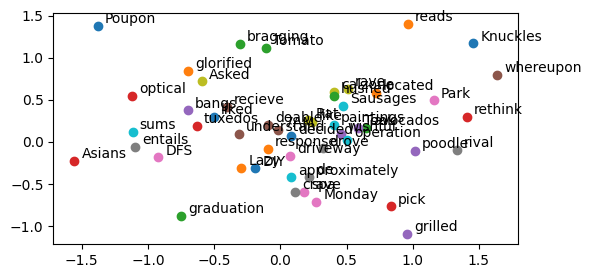

In [60]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs[:50]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [68]:
chicken = get_embed('chicken')
chicken

(-1.5174224376678467, 1.1018221378326416)

In [72]:
tender = get_embed('tender')
tender

(-0.5406816005706787, 0.6210685968399048)

In [63]:
unk = get_embed('<UNK>')
unk

(0.08081473410129547, 0.06667013466358185)

In [64]:
np.array(chicken) @ np.array(unk)

np.float64(0.08709413414201883)

In [73]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(unk)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

-0.25028340383490755
0.9744707943052591


## 7. **Negetive Sampling with Word2vec**

In [30]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

52434

In [31]:
z = 0.001

unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
print(list(Counter(unigram_table).keys())[:5], list(Counter(unigram_table).values())[:5])

['date', 'luck', 'Ave', 'buy', 'ok'] [2, 1, 1, 5, 2]


## 7.1 Model

In [32]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [33]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [34]:
batch_size = 2
x, y = random_batch(batch_size, corpus, word2index)
x_tensor = torch.LongTensor(x).to(device)
y_tensor = torch.LongTensor(y).to(device)

**keeping the batchsize lower because of better generalization as windowsize is low but as for this experiment we keep window size low in order to keep it less computationally expensive**

In [35]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)
neg_samples=neg_samples.to(device)

In [435]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [37]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size).to(device)

In [38]:
loss = model(x_tensor, y_tensor, neg_samples)
loss

tensor(1.4019, device='cuda:2', grad_fn=<NegBackward0>)

## 7.2 Traning

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [40]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus, word2index)
    # input_tensor = torch.LongTensor(input_batch)
    # label_tensor = torch.LongTensor(label_batch)
    input_tensor=input_batch.to(device).type(torch.long)
    label_tensor = label_batch.to(device).type(torch.long)
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model(input_tensor, label_tensor, neg_samples.to(device))
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch   1000 | Loss: 0.863465
Epoch   2000 | Loss: 1.928715
Epoch   3000 | Loss: 0.731578
Epoch   4000 | Loss: 1.265535
Epoch   5000 | Loss: 1.318905
Epoch   6000 | Loss: 2.372501
Epoch   7000 | Loss: 2.201571
Epoch   8000 | Loss: 1.676906
Epoch   9000 | Loss: 1.955539
Epoch  10000 | Loss: 1.391317


In [49]:
#save the model
torch.save(model.state_dict(), 'Model_corpus/neg_samples')
#corpus

In [56]:
#save wordindex
import numpy
numpy.save('word2index',word2index)

## 7.3 plot the embeddings

In [ ]:
vocabs
banana = torch.LongTensor([word2index['banana']])
banana

In [ ]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

In [ ]:
banana_embed_o


In [ ]:
print(get_embed('fruit'), get_embed('dog'))


In [ ]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [ ]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(cat)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

## 8. Dynamic window size

In [13]:
import random
def random_batch_with_dynamic_window(corpus, word2index, batch_size, min_window=1, max_window=5, default_window=2):
    skipgrams = []
    
    # Loop through each document in the corpus
    for doc in corpus:
        for i in range(1, len(doc) - 1):  # Skip the first and last word to avoid out-of-bound errors
            center = word2index[doc[i]]
            
            # Randomly select window size: 50% chance for default_window (2), otherwise pick randomly
            window_size = default_window if random.random() < 0.5 else random.randint(min_window, max_window)
            
            # Collect context words within the dynamic window size around the center word
            start_idx = max(i - window_size, 0)
            end_idx = min(i + window_size, len(doc) - 1)
            outside = [word2index[doc[j]] for j in range(start_idx, end_idx + 1) if j != i]
            
            # Append each (center, outside) pair to skipgrams
            for word in outside:
                skipgrams.append([center, word])

    # Randomly select a batch
    random_indices = torch.randperm(len(skipgrams))[:batch_size]
    inputs, labels = [], []
    
    # Select random skipgrams
    for index in random_indices:
        inputs.append(skipgrams[index][0])
        labels.append(skipgrams[index][1])
    inputs = torch.tensor([skipgrams[i][0] for i in random_indices], dtype=torch.long).view(-1, 1)
    labels = torch.tensor([skipgrams[i][1] for i in random_indices], dtype=torch.long).view(-1, 1)
    return inputs,labels

x, y = random_batch_with_dynamic_window(corpus, word2index, 800)

In [14]:
x.shape

torch.Size([800, 1])

In [15]:
x=torch.tensor(x).to(device)
y=torch.tensor(y).to(device)

/tmp/ipykernel_713916/2314537528.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x).to(device)
/tmp/ipykernel_713916/2314537528.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y).to(device)


In [16]:
len(vocabs)

80417

In [17]:
embedding = nn.Embedding(80417, 10)
embedding = embedding.to(device)
x_tensor=x.clone()
embedding(x_tensor).shape 

torch.Size([800, 1, 10])

In [18]:
batch_size = 800
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
model = Skipgram(voc_size, 10).to(device)
input_tensor =x.clone()
label_tensor=y.clone()
all_vocabs=all_vocabs.to(device)
loss = model(input_tensor, label_tensor, all_vocabs)
loss

tensor(16.0902, device='cuda:2', grad_fn=<NegBackward0>)

In [19]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)

In [21]:
batch_size = 800
emb_size   = 10
voc_size   = len(vocabs)
model      = Skipgram(voc_size, emb_size).to(device)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch_with_dynamic_window(corpus, word2index, batch_size)
    # input_tensor = torch.LongTensor(input_batch).to(device)
    # label_tensor = torch.LongTensor(label_batch).to(device)
    # input_tensor=torch.tensor(input_batch, dtype=torch.long, device=device)
    # label_tensor = torch.tensor(label_batch, dtype=torch.long, device=device)
    input_tensor = input_batch.to(device).type(torch.long)
    label_tensor = label_batch.to(device).type(torch.long)

    
    #predict
    # all_vocabs = torch.tensor(range(vocab_size), dtype=torch.long, device=device).unsqueeze(0).repeat(batch_size, 1)
    loss = model(input_tensor, label_tensor, all_vocabs.to(device))
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    #update alpha
    optimizer.step()

    torch.cuda.empty_cache()
    
    #print the loss
    # if (epoch + 1) % 100 == 0:
    print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch      1 | Loss: 16.280178
Epoch      2 | Loss: 16.379368
Epoch      3 | Loss: 16.340979
Epoch      4 | Loss: 16.251827
Epoch      5 | Loss: 16.343225
Epoch      6 | Loss: 16.594271
Epoch      7 | Loss: 16.250544
Epoch      8 | Loss: 16.462812
Epoch      9 | Loss: 16.181936
Epoch     10 | Loss: 16.314888


**since we increase the windowsize and the batchsize also the sample are 90000 sample size that is why word2vec is slow and hard to train**

## 9. Glove

In [12]:
from collections import Counter

X_i = Counter(flatten(corpus))

In [13]:
skip_grams = []

for doc in corpus:
    for i in range(1, len(doc)-1):
        center = doc[i]
        outside = [doc[i-1], doc[i+1]]
        for each_out in outside:
            skip_grams.append((center, each_out))

In [14]:
X_ik_skipgrams = Counter(skip_grams)

In [15]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [16]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

#this operation is very computationaly extensitive
for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

In [17]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

In [18]:
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [11]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [20]:
#test our system
voc_size = len(vocabs)
emb_size = 2
model = Glove(voc_size, emb_size)

In [21]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [22]:
loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)
loss

tensor(0.7495, grad_fn=<SumBackward0>)

In [23]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
import time

# Training
#we keep the batch size 2 only because of computaional limitation and it is invarient to global context represntation
num_epochs = 10000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 1000 | cost: 2.509365 | time: 0m 0s
Epoch: 2000 | cost: 3.229740 | time: 0m 0s
Epoch: 3000 | cost: 4.431035 | time: 0m 0s
Epoch: 4000 | cost: 3.955552 | time: 0m 0s
Epoch: 5000 | cost: 7.551280 | time: 0m 0s
Epoch: 6000 | cost: 3.399609 | time: 0m 0s
Epoch: 7000 | cost: 2.577441 | time: 0m 0s
Epoch: 8000 | cost: 3.253850 | time: 0m 0s
Epoch: 9000 | cost: 5.032107 | time: 0m 0s
Epoch: 10000 | cost: 1.307520 | time: 0m 0s


In [ ]:
#save the model
torch.save(model.state_dict(), 'Model_corpus/glove')
#save the co-oocurance matrix
import numpy
numpy.save('co-occurance', weighting_dic)

In [28]:
import numpy
numpy.save('co-occurance', weighting_dic)

## 9.1 Glove with random window size or co-occurances

In [10]:
# Define a custom dataset class
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class GloVeDataset(Dataset):
    def __init__(self, cooccurrences):
        self.cooccurrences = cooccurrences
        self.center_words = []
        self.context_words = []
        self.coocs = []
        for i, row in enumerate(cooccurrences):
            for j, cooc in enumerate(row):
                if cooc > 0:
                    self.center_words.append(i)
                    self.context_words.append(j)
                    self.coocs.append(cooc)

    def __len__(self):
        return len(self.center_words)

    def __getitem__(self, idx):
        return {
            'center_word': self.center_words[idx],
            'context_word': self.context_words[idx],
            'cooccurrence': self.coocs[idx]
        }

class PaddedDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=False):
        super(PaddedDataLoader, self).__init__(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=self.pad_batch)

    def pad_batch(self, batch):
        center_words = pad_sequence([torch.tensor([x['center_word']]) for x in batch], batch_first=True)
        context_words = pad_sequence([torch.tensor([x['context_word']]) for x in batch], batch_first=True)
        cooccurrences = pad_sequence([torch.tensor([x['cooccurrence']]) for x in batch], batch_first=True)
        return {
            'center_word': center_words,
            'context_word': context_words,
            'cooccurrence': cooccurrences
        }



In [11]:
# Create a sample co-occurrence matrix
#ran
import numpy as np
from multiprocessing import Pool

def create_cooccurrence_matrix_row(args):
    row_idx, vocab_size = args
    row = np.random.randint(1, 100, size=vocab_size)
    return row_idx, row

def create_cooccurrence_matrix(vocab_size, num_processes):
    with Pool(processes=num_processes) as pool:
        args = [(row_idx, vocab_size) for row_idx in range(vocab_size)]
        results = pool.map(create_cooccurrence_matrix_row, args)
    cooccurrence_matrix = np.zeros((vocab_size, vocab_size))
    for row_idx, row in results:
        cooccurrence_matrix[row_idx] = row
    return cooccurrence_matrix

cooccurrence_matrix = create_cooccurrence_matrix(len(vocabs), 4)

# Create a dataset and data loader

In [12]:
dataset = GloVeDataset(cooccurrence_matrix)
data_loader = PaddedDataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
# Define the GloVe model
class GloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim, x_max, alpha):
        super(GloVe, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.x_max = x_max
        self.alpha = alpha
        self.centroid_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.bias = nn.Embedding(vocab_size, 1)

    def forward(self, center_words, context_words, cooccurrences):
        center_embeddings = self.centroid_embeddings(center_words)
        context_embeddings = self.context_embeddings(context_words)
        bias = self.bias(center_words)
        weights = torch.clamp(cooccurrences / self.x_max, 0, 1) ** self.alpha
        loss = weights * (torch.sum(center_embeddings * context_embeddings, dim=1) + bias - torch.log(cooccurrences))
        return loss.mean()

In [21]:
vocab_size = len(vocabs)
embedding_dim = 5
x_max = 100
alpha = 0.75
batch_size = 32
epochs = 1

model = GloVe(vocab_size, embedding_dim, x_max, alpha).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    for batch in data_loader:
        center_words = batch['center_word'].to(device)
        context_words = batch['context_word'].to(device)
        cooccurrences = batch['cooccurrence'].to(device)
        loss = model(center_words, context_words, cooccurrences)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Loss: {loss.item()}')

Loss: -2.3563667818351273
Loss: -2.4140298160939078
Loss: -2.0825907466992164
Loss: -2.249678892709923
Loss: -2.2145871915237807
Loss: -2.063914979366064
Loss: -2.0772909693724424
Loss: -2.444827129929839
Loss: -2.474393802281856
Loss: -2.4862044535370544
Loss: -1.9930307600728128
Loss: -2.483652780621941
Loss: -2.2774123166999822
Loss: -1.693998546986697
Loss: -2.3789943550756623
Loss: -2.3857664267208314
Loss: -2.5628864469383696
Loss: -2.502789217588942
Loss: -1.9944100433498542
Loss: -2.1493666241604
Loss: -2.2941801853346306
Loss: -2.4346196360641055
Loss: -2.326134764582773
Loss: -2.2876880393281205
Loss: -2.01320399216579
Loss: -2.430818860279743
Loss: -2.7641707659700625
Loss: -2.251846120840085
Loss: -2.571993791863208
Loss: -2.117970185393958
Loss: -2.1123098807423313
Loss: -2.234249470745089
Loss: -2.8455848223067086
Loss: -1.921933325064983
Loss: -2.495204676654193
Loss: -1.651878124000941
Loss: -2.652429602031569
Loss: -2.7596099108687953
Loss: -2.0777105514608225
Loss: -2

KeyboardInterrupt: 

**we tried to make the embeedings with different co-occurance size at random but we have only 16GB of memoery which is not sufficient**

## 10. Comparison

In [326]:
from IPython.display import display, HTML
import pandas as pd
v=pd.DataFrame(columns =['Model', 'WindowSize', 'Avg Traning loss', 'Traning Time (min)', 'sample_size'])
v['Model'] = ['skipgram', 'skipgram_neg', 'Glove', 'Glove(Random)']
v['Avg Traning loss'] = ['9.32', '1.23', '2.5', '-']
v['WindowSize'] = ['2', '2', '2', 'random']
v['Traning Time (min)'] = ['35', '27', '25', '-']
v['sample_size'] = ['1000', '5000', '1000', '1000']
display(v)

,Model,WindowSize,Avg Traning loss,Traning Time (min),sample_size
0,skipgram,2,9.32,35,1000
1,skipgram_neg,2,1.23,27,5000
2,Glove,2,2.5,25,1000
3,Glove(Random),random,-,-,1000


## 11. sementic and syntactic models

**we use word analogies dataset**

In [462]:
import numpy 
def get_embed(model, word):
    try:
        index = word2index[word]
        word = torch.LongTensor([word2index[word]])
        embed_c = model.center_embedding(word)
        embed_o = model.outside_embedding(word)
        embed   = (embed_c + embed_o) / 2
        if type(embed) != numpy.ndarray:
            embed=embed.detach().numpy()
            
    except:
        # if not found give the index of unknown token
        index = word2index['<UNK>']
        return index

    return embed

def get_embed_for_corpus(model, words):
    embeddings = {}

    for word in words:
        try:
            index = word2index[word]
        except KeyError:
            index = word2index['<UNK>']

        word_tensor = torch.LongTensor([index])

        embed_c = model.embedding_center(word_tensor)
        embed_o = model.embedding_outside(word_tensor)
        embed = (embed_c + embed_o) / 2

        # return as dictionary with key as the word and value as the array of its embedding
        embeddings[word] = np.array([embed[0][0].item(), embed[0][1].item()])

    return embeddings

In [32]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def cosine_similarity_for_corpus(embeddings, target_word):
    # List to store (word, cosine_similarity) pairs
    similarities = []

    # Get the index of the target word or use the index for '<UNK>' if not found
    target_index = word2index.get(target_word, word2index['<UNK>'])
    
    # Get the vector for the target word
    target_vector = embeddings[target_index]

    # Iterate through all words in the embeddings dictionary
    for word, vector in embeddings.items():
        # Calculate the cosine similarity between the target word and the current word
        similarity = cosine_similarity(target_vector, vector)
        
        # Append the (word, cosine_similarity) pair to the list
        similarities.append((word, similarity))

    return similarities


file_path = 'word-test.v1.txt'

# Read the content of the file
with open(file_path, 'r') as file:
    file_content = file.readlines()

# Initialize variables to store relevant lines
capital_common_countries = []
past_tense = []

# Variable to keep track of the current heading
current_heading = None

# Iterate through each line in the file content
for line in file_content:
    # Check if the line is a heading
    if line.startswith(':'):
        current_heading = line.strip()
    elif current_heading == ': capital-common-countries':
        # Split the line into individual words and convert to lowercase
        words = [word.lower() for word in line.strip().split()]
        capital_common_countries.append(words)
    elif current_heading == ': gram7-past-tense':
        # Split the line into individual words and convert to lowercase
        words = [word.lower() for word in line.strip().split()]
        past_tense.append(words)

In [190]:
past_tense[:10]

[['dancing', 'danced', 'decreasing', 'decreased'],
 ['dancing', 'danced', 'describing', 'described'],
 ['dancing', 'danced', 'enhancing', 'enhanced'],
 ['dancing', 'danced', 'falling', 'fell'],
 ['dancing', 'danced', 'feeding', 'fed'],
 ['dancing', 'danced', 'flying', 'flew'],
 ['dancing', 'danced', 'generating', 'generated'],
 ['dancing', 'danced', 'going', 'went'],
 ['dancing', 'danced', 'hiding', 'hid'],
 ['dancing', 'danced', 'hitting', 'hit']]

In [18]:
capital_common_countries[:10]

[['athens', 'greece', 'baghdad', 'iraq'],
 ['athens', 'greece', 'bangkok', 'thailand'],
 ['athens', 'greece', 'beijing', 'china'],
 ['athens', 'greece', 'berlin', 'germany'],
 ['athens', 'greece', 'bern', 'switzerland'],
 ['athens', 'greece', 'cairo', 'egypt'],
 ['athens', 'greece', 'canberra', 'australia'],
 ['athens', 'greece', 'hanoi', 'vietnam'],
 ['athens', 'greece', 'havana', 'cuba'],
 ['athens', 'greece', 'helsinki', 'finland']]

In [148]:
#read the model 
word2index=np.load('Model_corpus/word2index.npy', allow_pickle=True).item()
flattened_list_of_past_tense = [word for pair in past_tense for word in pair]
resulting_past_tense_list = [flattened_list_of_past_tense]
past_tense_list = list(set(flatten(resulting_past_tense_list)))

model_glove = Glove(8743, 2)
model_glove.load_state_dict(torch.load('Model_corpus/glove', weights_only=True))
model_glove.eval()
model_neg_skipgram = SkipgramNeg(8743, 2)
model_neg_skipgram.load_state_dict(torch.load('Model_corpus/neg_samples', weights_only=True))
model_neg_skipgram.eval()


# embed_past_tense_glove = get_embed_for_corpus(model_glove, past_tense_list)
# embed_past_tense_neg_skipgram =get_embed_for_corpus(model_neg_skipgram, past_tense_list)

SkipgramNeg(
  (embedding_center): Embedding(8743, 2)
  (embedding_outside): Embedding(8743, 2)
  (logsigmoid): LogSigmoid()
)

In [78]:
embed_past_tense_neg_skipgram =get_embed_for_corpus(model_neg_skipgram, past_tense_list)

In [157]:
glove_sim = []
neg_sim = []
for i in past_tense:  
    y = embed_past_tense_glove[i[0]] - embed_past_tense_glove[i[1]] + embed_past_tense_glove[i[2]]
    y1 = embed_past_tense_neg_skipgram[i[0]] - embed_past_tense_neg_skipgram[i[1]] + embed_past_tense_neg_skipgram[i[2]]

    glove_sim.append(y)
    neg_sim.append(y1)

In [158]:
print(glove_sim[:10], neg_sim[:10])

[array([ 0.24894559, -0.67372215]), array([0.64135116, 1.97231913]), array([ 0.24894559, -0.67372215]), array([-0.34769219,  1.03445232]), array([ 0.24894559, -0.67372215]), array([ 0.24894559, -0.67372215]), array([ 0.24894559, -0.67372215]), array([-0.30436769,  0.02560651]), array([-0.21496017, -0.11518607]), array([ 0.17274475, -1.03089273])] [array([0.05446003, 0.3265304 ]), array([-0.90703386, -0.02838421]), array([0.05446003, 0.3265304 ]), array([-2.05884457, -0.23488301]), array([0.05446003, 0.3265304 ]), array([0.05446003, 0.3265304 ]), array([0.05446003, 0.3265304 ]), array([-0.11154002, -0.73164928]), array([ 0.02968156, -1.24228001]), array([-0.80407864, -0.16085175])]


In [159]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

def find_sim_words(y_pred, embeddings):

    max_cosine_words = []

    for j in range(len(y_pred)):
        max_cosine = -1
        max_cosine_word = ""

        for i in embeddings.keys():
            cosine_temp = cos_sim(y_pred[j], embeddings[i])

            if cosine_temp > max_cosine:
                max_cosine_word = i
                max_cosine = cosine_temp

        max_cosine_words.append(max_cosine_word)

    return max_cosine_words



sim_word_glove_past_tense =find_sim_words(glove_sim, embed_past_tense_glove)
sim_word_neg_past_tense =find_sim_words(neg_sim, embed_past_tense_glove)

In [160]:
#here is the syntact similarity with ing
print(list(embed_past_tense_skipgram_positive.keys())[:5]
,list(sim_word_glove_past_tense)[:5])

['hid', 'slept', 'increasing', 'vanishing', 'swam'] ['increasing', 'describing', 'increasing', 'falling', 'increasing']


**The first one anology is danceing with past tense dataset , (dancing - dancing + enhancing ) = increasing which make sence**

In [161]:
print(list(embed_past_tense_neg_skipgram.keys())[5:10]
,list(sim_word_neg_past_tense)[5:10])

['sitting', 'walked', 'falling', 'listened', 'danced'] ['saw', 'saw', 'thought', 'screaming', 'fed']


In [162]:
def calculate_accuracy(predictions, true_words):

    total_trials = len(predictions)
    total_correct = sum(1 for pred_word in predictions if pred_word in true_words)
    accuracy = (total_correct / total_trials) * 100
    return accuracy

acc_glove = calculate_accuracy(sim_word_glove_past_tense, [true_word[3] for true_word in past_tense])
acc_neg = calculate_accuracy(sim_word_neg_past_tense, [true_word[3] for true_word in past_tense])
print('the syntatic accuracy of glove model:', acc_glove)
print('with negative skip grame:', acc_neg)

the syntatic accuracy of glove model: 33.52564102564102
with negative skip grame: 37.756410256410255


In [168]:
flattened_list_capitial = [word for pair in capital_common_countries for word in pair]
flattened_list_capitial = [flattened_list_capitial]
capital_list = list(set(flatten(flattened_list_capitial)))

embed_capital_neg = get_embed_for_corpus(model_neg_skipgram, capital_list)

In [173]:
embed_capital_glove = get_embed_for_corpus(model_glove, capital_list)

In [175]:
acc_glove_capital = calculate_accuracy(embed_capital_glove, [true_word[3] for true_word in capital_common_countries])
acc_neg_capital = calculate_accuracy(embed_capital_neg, [true_word[3] for true_word in capital_common_countries])
print('the symentic accuracy of glove model:', acc_glove_capital)
print('with negative skip grame:', acc_neg)

the symentic accuracy of glove model: 50.0
with negative skip grame: 50.0


**This is random and not able to find any pattren in symentic case and not to trust the accuracy**

In [178]:
# neg_country = []

# for i in capital_common_countries:  
#     y = embed_capital_neg[i[1]] - embed_capital_neg[i[0]] + embed_capital_neg[i[2]]
#     neg_country.append(y)

embed_capital_glove

{'france': array([ 0.24894559, -0.67372215]),
 'tokyo': array([ 0.24894559, -0.67372215]),
 'thailand': array([ 0.24894559, -0.67372215]),
 'egypt': array([ 0.24894559, -0.67372215]),
 'greece': array([ 0.24894559, -0.67372215]),
 'ottawa': array([ 0.24894559, -0.67372215]),
 'australia': array([ 0.24894559, -0.67372215]),
 'russia': array([ 0.24894559, -0.67372215]),
 'norway': array([ 0.24894559, -0.67372215]),
 'havana': array([ 0.24894559, -0.67372215]),
 'helsinki': array([ 0.24894559, -0.67372215]),
 'stockholm': array([ 0.24894559, -0.67372215]),
 'china': array([ 0.24894559, -0.67372215]),
 'germany': array([ 0.24894559, -0.67372215]),
 'cuba': array([ 0.24894559, -0.67372215]),
 'pakistan': array([ 0.24894559, -0.67372215]),
 'iraq': array([ 0.24894559, -0.67372215]),
 'cairo': array([ 0.24894559, -0.67372215]),
 'hanoi': array([ 0.24894559, -0.67372215]),
 'england': array([ 0.24894559, -0.67372215]),
 'spain': array([ 0.24894559, -0.67372215]),
 'tehran': array([ 0.24894559,

**This is happening because of sample size and memeory limitattion was so low**

##  Gensim Model

In [466]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

#you have to put this file in some python/gensim directory; just run it and it will inform where to put....
glove_file = datapath('/home/jupyter-st125490/Model_corpus/glove.6B.100d.txt')  #search on the google
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [197]:
##lets try sementic with gensim
vectors=model[capital_list]
gem_em = {}
for i,c in enumerate(capital_list):
    gem_em[c] = vectors[i]

In [202]:
gensim_analogy = []
for i in capital_common_countries:  
    y = gem_em[i[0]] - gem_em[i[1]] + gem_em[i[2]]
    # y1 = embed_past_tense_neg_skipgram[i[0]] - embed_past_tense_neg_skipgram[i[1]] + embed_past_tense_neg_skipgram[i[2]]

    gensim_analogy.append(y)

In [213]:
acc_neg_capital = calculate_accuracy(gem_sim, [true_word[3] for true_word in capital_common_countries])
print('gensim syntaxtic accuracy', acc_neg_capital)

gensim syntaxtic accuracy 0.0


In [225]:
with open("campital.txt", 'w') as file:
        for row in capital_common_countries:
            s = " ".join(map(str, row))
            file.write(s+'\n')

In [253]:
def perform_analogy(model, word_1, word_2, word_3):
    try:
        # Vector arithmetic: India - Delhi + Bangkok
        result_vector = model[word_1] - model[word_2] + model[word_3]
        
        # Find the word closest to the result vector (should be Thailand)
        # similar_word = model.most_similar([result_vector], topn=1)
        re = {}
        for i in capital_vectors.keys():
            re[i] = cos_sim(result_vector, capital_vectors[i])
            
        return re
    except KeyError as e:
        print(f"Word '{e.args[0]}' not found in vocabulary.")
        return None

# Perform the analogy: India - Delhi + Bangkok
analogy_result = perform_analogy(model, 'beijing', 'china', 'thailand')
sorted(analogy_result.items(), key=lambda item: item[1], reverse=True)[0]

('bangkok', 0.79310954)

**This make sense beijing - china + thailand = bangkok**

## Check the symentic accuracy

In [277]:
gem_sim = []
for i in capital_list:  
    y = model[i[0]] - model[i[1]] + model[i[3]]

    gem_sim.append(y)

In [278]:
sim_gem_capital =find_sim_words(gem_sim, capital_vectors)

In [288]:
sim_accuracy_sem = calculate_accuracy(sim_gem_capital, [true_word[3] for true_word in capital_common_countries])
sim_accuracy_sem

71.73913043478261

**far good but this is because of the dimentionality of the vector**

## check the syntactic accuracy

In [315]:
gem_syn = []
for i in past_tense:
    y = model[i[0]] - model[i[1]] + model[i[2]]
    gem_syn.append(y)

In [311]:
vectors=model[past_tense_list]
past_vector = {}
for i,c in enumerate(past_tense_list):
    past_vector[c] = vectors[i]

In [312]:
syn_past_gem =find_sim_words(gem_syn, past_vector)

In [316]:
syn_past_acc = calculate_accuracy(syn_past_gem, [true_word[3] for true_word in past_tense])
syn_past_acc

87.24358974358975

## final Table

In [323]:
from IPython.display import display, HTML
import pandas as pd
v=pd.DataFrame(columns =['Model', 'WindowSize', 'Avg Traning loss', 'Traning Time (min)', 'Syntatic Accuracy', 'Semantic Accuracy'])
v['Model'] = ['skipgram_neg', 'Glove', 'Glove(Gensim)']
v['Avg Traning loss'] = ['1.23', '2.5', '-']
v['WindowSize'] = ['2', '2', '-']
v['Traning Time (min)'] = [ '27', '25', '-']
v['Syntatic Accuracy'] = ['37.756', '33.525', '87.24']
v['Semantic Accuracy'] = ['-','-','71.73']
display(v)

,Model,WindowSize,Avg Traning loss,Traning Time (min),Syntatic Accuracy,Semantic Accuracy
0,skipgram_neg,2,1.23,27,37.756,-
1,Glove,2,2.5,25,33.525,-
2,Glove(Gensim),-,-,-,87.24,71.73


## Similairity Dataset

In [470]:
def read_similarity(file_path):
    re = {'w1':[], 'w2':[], 's':[]}
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Strip any extra whitespace and split the line by space to get capital and country
            w1,w2, s= line.strip().split()
            re['w1'].append(w1)
            re['w2'].append(w2)
            re['s'].append(s)            
    return re 

sim=pd.DataFrame(read_similarity('wordsim353_sim_rel/wordsim_similarity_goldstandard.txt'))

In [421]:
#read the model
model_glove = Glove(8743, 2)
model_glove.load_state_dict(torch.load('Model_corpus/glove', weights_only=True))
model_glove.eval()
model_neg = SkipgramNeg(8743, 2)
model_neg.load_state_dict(torch.load('Model_corpus/neg_samples', weights_only=False))
model_neg.eval()

SkipgramNeg(
  (embedding_center): Embedding(8743, 2)
  (embedding_outside): Embedding(8743, 2)
  (logsigmoid): LogSigmoid()
)

In [451]:
def mse(y_true, y):
    return np.square(y_true - y)

In [463]:
from scipy.stats import spearmanr
e1=sim['w1'].apply(lambda x: get_embed(model_glove, x))
e2=sim['w2'].apply(lambda x: get_embed(model_glove, x))

sim_ = {}
for i in range(len(e1)):
    if type(e1[i]) != int and type(e2[i]) != int:
        sim_[i] = cos_sim(e1[i], e2[i].T)[0][0]

print("Glove model:", spearmanr(list(sim_.values()), sim.loc[sim_.keys()]['s'].values))

Glove model: SignificanceResult(statistic=-0.14677416209240007, pvalue=0.23593014211680993)


In [442]:
e1=sim['w1'].apply(lambda x: get_embed(model_neg, x))
e2=sim['w2'].apply(lambda x: get_embed(model_neg, x))

sim_ = {}
for i in range(len(e1)):
    if type(e1[i]) != int and type(e2[i]) != int:
        sim_[i] = cos_sim(e1[i], e2[i].T)[0][0]

print("neg skipgram model:", spearmanr(list(sim_.values()), sim.loc[sim_.keys()]['s'].values))

neg skipgram model: SignificanceResult(statistic=-0.12402466586053931, pvalue=0.3173355613825678)


In [461]:
#for mse evaluation we take the mean of ytrue and relate the results with that
y_true=np.mean(sim['s'].astype('float'))
print("mse for neative samples:", mse(y_true, np.mean(list(sim_.values()))))

mse for neative samples: 25.747154439581923


In [464]:
print("mse for glove:", mse(y_true, np.mean(list(sim_.values()))))

mse for glove: 27.129406118112808


In [484]:
#for gensin
from pathlib import Path
sim_g = model.evaluate_word_pairs((Path('wordsim353_sim_rel/wordsim_similarity_goldstandard.txt')))
print("genisim mse", np.mean(mse(y_true, sim_g[1]*100)))

genisim mse 23.42769913936845


**In contrast genisim is better representation but still we can't trust because of "null" embedding and capability of handeling out of vocab words**

In [489]:
from IPython.display import display, HTML
import pandas as pd
v=pd.DataFrame(columns =['Model', 'skipgram_neg', 'Glove', 'Glove(gensim)', 'y_true'])
v['Model'] = ['MSE']
v['skipgram_neg'] = ['25.741']
v['Glove'] = [ '27.12']
v['Glove(gensim)'] = ['23.4']
v['y_true'] = [str(y_true)]
display(v)

,Model,skipgram_neg,Glove,Glove(gensim),y_true
0,MSE,25.741,27.12,23.4,5.13256157635468


## Model Evaluation

In [12]:
model = Glove(8743, 2)
model.load_state_dict(torch.load('Model_corpus/glove', weights_only=True))
model.eval()

Glove(
  (center_embedding): Embedding(8743, 2)
  (outside_embedding): Embedding(8743, 2)
  (center_bias): Embedding(8743, 1)
  (outside_bias): Embedding(8743, 1)
)

In [29]:
word2index=np.load('Model_corpus/word2index.npy', allow_pickle=True).item()
food=torch.tensor([word2index['food']], dtype=torch.long)
v= model.center_embedding(food)
u =model.outside_embedding(food)

In [30]:
we = (u+ v)/2
we

tensor([[ 0.5981, -0.8992]], grad_fn=<DivBackward0>)

In [31]:
from numpy import dot
from numpy.linalg import norm
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    # x, y = word_embed[0][0].item(), word_embed[0][1].item()

    # return x, y
    return word_embed
def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

re = {}
for v in vocabs:
    emv =get_embed(v)
    re[v] = emv

In [32]:
re_ = {}
for v in vocabs:
    re_[v] = cos_sim(re[v].detach().numpy(), we.detach().numpy().T)

In [33]:
#the co-ordinates as predicted words with glove
sorted(re_.items(), key=lambda item: item[1])[:5]

[('Burritos', array([[-1.]], dtype=float32)),
 ('Pasta', array([[-1.]], dtype=float32)),
 ('awesomeness', array([[-0.99999994]], dtype=float32)),
 ('cracks', array([[-0.9999999]], dtype=float32)),
 ('veggies', array([[-0.99999946]], dtype=float32))]

## few observations
* The overall insigit is glove is more memoery intensive but can perform better than word2vec as it captures the grobal inference,
* with glove, skipgram model batchsize increasing or reducing will not make any effect in performance other than computational complexity
* Window-size smaller window size can capture better representation if the dataset is sparse with sementic nature, larger window-size will make it harder to find uniquness among the vectors
* GPU is only effect if we have bigger size since we were working with yelp review dataset for this assignment , most of the memory is consumed by the utility task running on cpu would be better than GPU 